In [37]:
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score

from sklearn import model_selection
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

In [38]:
import sklearn

In [39]:
pd.set_option('display.max_columns',None)

## Import cleaned dataset
### Simple model using just Abn% + demographics

In [43]:
pos_final_test = pd.read_csv('./data/pos_KNN_final_test.csv.gz', compression='gzip')

model_cols = pos_final_test.columns.str.contains('abn') | pos_final_test.columns.isin(['gender', 'age','ethnicity_AMERICAN INDIAN/ALASKA NATIVE', 'ethnicity_ASIAN','ethnicity_BLACK/AFRICAN AMERICAN', 'ethnicity_HISPANIC/LATINO','ethnicity_OTHER', 'ethnicity_UNKNOWN'])
hadm_features = pos_final_test.loc[:, model_cols]
hadm_target = pos_final_test.loc[:, 'pos']

# pos_final_test.columns.str.contains('mean') | pos_final_test.columns.str.contains('below') |pos_final_test.columns.str.contains('above') |

In [5]:
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# hadm_features['ethnicity'] = le.fit_transform(hadm_features['ethnicity'])
# hadm_features['gender'] = le.fit_transform(hadm_features['gender'])

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# hadm_features['age'] = scaler.fit_transform(hadm_features['age'].values.reshape(-1, 1))

In [104]:
hadm_features

,"('abn_percent', 50868)","('abn_percent', 50882)","('abn_percent', 50902)","('abn_percent', 50912)","('abn_percent', 50931)","('abn_percent', 50971)","('abn_percent', 50983)","('abn_percent', 51006)","('abn_percent', 51221)","('abn_percent', 51222)","('abn_percent', 51248)","('abn_percent', 51249)","('abn_percent', 51250)","('abn_percent', 51265)","('abn_percent', 51277)","('abn_percent', 51279)","('abn_percent', 51301)",gender,age,ethnicity_AMERICAN INDIAN/ALASKA NATIVE,ethnicity_ASIAN,ethnicity_BLACK/AFRICAN AMERICAN,ethnicity_HISPANIC/LATINO,ethnicity_OTHER,ethnicity_UNKNOWN
0,0.965474,2.958378,-0.236040,1.775190,1.059667,-0.391195,1.493924,1.799380,0.349508,0.271983,-0.631844,-0.650272,-0.461956,0.187436,-0.498606,0.667032,1.770726,0.0,1.153246,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.346028,-0.552401,1.321157,0.417674,0.157940,-0.391195,-0.411612,-0.797160,0.783332,0.756098,-0.631844,2.157373,1.358548,-0.600116,-0.498606,0.667032,-0.324457,0.0,-0.441483,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.346028,0.314458,3.224398,1.629742,1.059667,0.293753,1.684477,1.474812,-1.602697,-1.664476,1.576326,-0.650272,2.572217,-0.239155,-0.498606,0.667032,0.133864,1.0,1.359017,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.346028,-0.552401,-0.582084,-0.551980,-1.645515,-0.391195,-0.411612,-0.797160,0.783332,0.756098,1.891779,-0.650272,2.572217,-0.600116,-0.498606,0.667032,-0.848253,0.0,-1.316012,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.346028,-0.552401,-0.582084,-0.551980,1.059667,-0.391195,-0.411612,-0.797160,-1.602697,0.756098,-0.631844,-0.650272,-0.461956,-0.600116,-0.498606,0.667032,1.770726,0.0,-1.110241,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8555,-0.346028,-0.552401,-0.582084,-0.551980,-1.645515,-0.391195,-0.411612,-0.797160,-1.602697,0.756098,-0.631844,-0.650272,-0.461956,-0.600116,-0.498606,0.667032,-0.848253,1.0,-0.132826,0.0,0.0,0.0,0.0,1.0,0.0
8556,-0.346028,-0.552401,-0.582084,2.356982,-1.645515,-0.391195,-0.411612,1.799380,0.783332,0.756098,1.891779,-0.650272,2.572217,-0.600116,-0.498606,0.667032,-0.848253,0.0,1.050360,0.0,0.0,0.0,0.0,0.0,0.0
8557,-0.346028,1.831461,2.801456,-0.551980,1.059667,-0.391195,4.828610,-0.797160,0.783332,0.756098,-0.631844,-0.650272,2.572217,-0.600116,-0.498606,0.667032,0.024740,0.0,1.564789,0.0,1.0,0.0,0.0,0.0,0.0
8558,2.308203,-0.459524,1.230526,-0.551980,0.802030,-0.065030,2.208499,1.304801,0.713155,0.756098,-0.631844,0.010350,-0.461956,1.608120,2.332418,0.667032,-0.000936,0.0,0.433046,0.0,0.0,0.0,0.0,0.0,0.0


## Train test split

In [46]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(hadm_features, hadm_target, test_size=.2, stratify=hadm_target, random_state=25)

In [47]:
# Over and under sample the train set
sm = SMOTE()
X_res_over, y_res_over = sm.fit_resample(X_train, y_train)

nm = NearMiss()
X_res_under, y_res_under = nm.fit_resample(X_train, y_train)

In [48]:
# check target counts
print('Target=0: ',hadm_target[hadm_target==0].count())
print('Target=1: ',hadm_target[hadm_target==1].count())

Target=0:  7362
Target=1:  1198


In [73]:
def results(model):
    '''
    Function to report on the metrics of a GridSearch model.
    Input: GridSearchCV model
    Prints: CV score, best parameters, accuracy, precision, recall, F1, confusion matrix and ROCAUC
    '''
    
#     cross validation scores
    print("Cross Validation")
    print("-" * 20)
    print("Best parameter: ", model.best_params_)
    print("Best CV score:  %.4f" % model.best_score_)

#     confusion matrix & related scores
    pred = model.best_estimator_.predict(X_test)
    print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
    print("_______________________________________________")
    print("Classification Report:", end='')
    print(f"\tPrecision Score: {precision_score(y_test, pred) * 100:.2f}%")
    print(f"\t\t\tRecall Score: {recall_score(y_test, pred) * 100:.2f}%")
    print(f"\t\t\tF1 score: {f1_score(y_test, pred) * 100:.2f}%")
    print(f"\t\t\tROC_AUC score: {roc_auc_score(y_test, pred) * 100:.2f}%")
    print("_______________________________________________")
    print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")
    
    svc_disp = plot_roc_curve(model, X_test, y_test)
    plt.show()
    
    if model.estimator.__class__== sklearn.linear_model._logistic.LogisticRegression:
        est_coefs = pd.Series(model.best_estimator_.coef_[0], index=X_train.columns)
        sortedCoefs = np.abs(est_coefs).sort_values(ascending=False)
        print(sortedCoefs[sortedCoefs > 0].head(25))
      
    else:
        est_coefs = pd.Series(model.best_estimator_.feature_importances_, index=X_train.columns)
        sortedCoefs = est_coefs.sort_values(ascending=False)
        print(sortedCoefs.head(25))

## Logistic Regression

### Basic

In [74]:
%%time

params ={'C':np.linspace(1e-2,1,20)}
logReg = LogisticRegression(penalty = 'l1', max_iter = 2000, class_weight = "balanced", solver = 'liblinear')

grid_log = GridSearchCV(estimator = logReg, param_grid = params, cv = 3, scoring='roc_auc')
grid_log.fit(X_train, y_train)

CPU times: user 3.23 s, sys: 385 ms, total: 3.61 s
Wall time: 2.36 s


GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=2000, penalty='l1',
                                          solver='liblinear'),
             param_grid={'C': array([0.01      , 0.06210526, 0.11421053, 0.16631579, 0.21842105,
       0.27052632, 0.32263158, 0.37473684, 0.42684211, 0.47894737,
       0.53105263, 0.58315789, 0.63526316, 0.68736842, 0.73947368,
       0.79157895, 0.84368421, 0.89578947, 0.94789474, 1.        ])},
             scoring='roc_auc')

Cross Validation
--------------------
Best parameter:  {'C': 0.06210526315789474}
Best CV score:  0.8315
Accuracy Score: 74.53%
_______________________________________________
Classification Report:	Precision Score: 31.85%
			Recall Score: 71.67%
			F1 score: 44.10%
			ROC_AUC score: 73.33%
_______________________________________________
Confusion Matrix: 
 [[1104  368]
 [  68  172]]



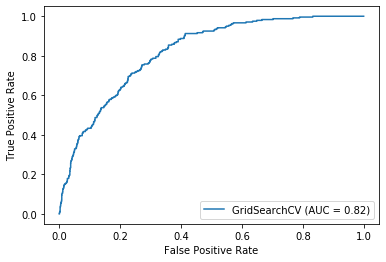

age                                 0.924954
('abn_percent', 51006)              0.367268
('abn_percent', 51277)              0.365247
('abn_percent', 51221)              0.356932
('abn_percent', 51222)              0.336503
('abn_percent', 50912)              0.293142
('abn_percent', 50931)              0.199714
('abn_percent', 51249)              0.149206
ethnicity_BLACK/AFRICAN AMERICAN    0.148948
gender                              0.140296
('abn_percent', 50971)              0.061245
('abn_percent', 51301)              0.049881
('abn_percent', 51250)              0.045587
('abn_percent', 50882)              0.037655
('abn_percent', 51248)              0.029490
('abn_percent', 50868)              0.017237
('abn_percent', 50902)              0.014745
('abn_percent', 51265)              0.000404
dtype: float64


In [75]:
results(grid_log)

### Over Sampling using SMOTE

In [76]:
%%time
params ={'C':np.linspace(1e-2,1,20)}
logReg = LogisticRegression(penalty = 'l1', max_iter = 2000, class_weight = "balanced", solver = 'liblinear')

grid_log_over = GridSearchCV(estimator = logReg, param_grid = params, cv = 3, scoring='roc_auc')
grid_log_over.fit(X_res_over, y_res_over)

CPU times: user 4.67 s, sys: 546 ms, total: 5.22 s
Wall time: 3.21 s


GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=2000, penalty='l1',
                                          solver='liblinear'),
             param_grid={'C': array([0.01      , 0.06210526, 0.11421053, 0.16631579, 0.21842105,
       0.27052632, 0.32263158, 0.37473684, 0.42684211, 0.47894737,
       0.53105263, 0.58315789, 0.63526316, 0.68736842, 0.73947368,
       0.79157895, 0.84368421, 0.89578947, 0.94789474, 1.        ])},
             scoring='roc_auc')

Cross Validation
--------------------
Best parameter:  {'C': 0.16631578947368422}
Best CV score:  0.8409
Accuracy Score: 74.65%
_______________________________________________
Classification Report:	Precision Score: 31.56%
			Recall Score: 69.17%
			F1 score: 43.34%
			ROC_AUC score: 72.36%
_______________________________________________
Confusion Matrix: 
 [[1112  360]
 [  74  166]]



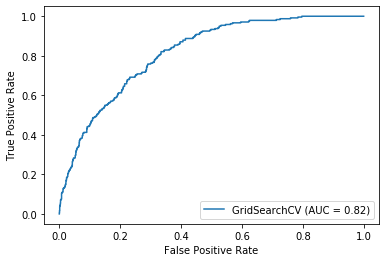

age                                 1.074909
ethnicity_OTHER                     0.445124
('abn_percent', 51222)              0.429066
('abn_percent', 51221)              0.415828
ethnicity_ASIAN                     0.391320
('abn_percent', 51006)              0.387847
('abn_percent', 51277)              0.381210
('abn_percent', 50912)              0.283064
('abn_percent', 50931)              0.269844
gender                              0.253226
('abn_percent', 51249)              0.158655
('abn_percent', 51248)              0.137546
('abn_percent', 51250)              0.126906
ethnicity_UNKNOWN                   0.113744
('abn_percent', 50971)              0.112895
('abn_percent', 51301)              0.067700
('abn_percent', 51279)              0.038827
ethnicity_BLACK/AFRICAN AMERICAN    0.029040
('abn_percent', 50983)              0.010644
('abn_percent', 50882)              0.008062
('abn_percent', 51265)              0.007245
dtype: float64


In [77]:
results(grid_log_over)

### Under Sampling using Near Miss

In [78]:
%%time
params ={'C':np.linspace(1e-2,100,100)}
logReg = LogisticRegression(penalty = 'l1', max_iter = 2000, class_weight = "balanced", solver = 'liblinear')

grid_log_under = GridSearchCV(estimator = logReg, param_grid = params, cv = 3, scoring='roc_auc')
grid_log_under.fit(X_res_under, y_res_under)

CPU times: user 8.44 s, sys: 727 ms, total: 9.17 s
Wall time: 5.55 s


GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=2000, penalty='l1',
                                          solver='liblinear'),
             param_grid={'C': array([1.000e-02, 1.020e+00, 2.030e+00, 3.040e+00, 4.050e+00, 5.060e+00,
       6.070e+00, 7.080e+00, 8.090e+00, 9.100e+00, 1.011e+01, 1.112e+01,
       1.213e+01, 1.314e+01, 1.415e+01, 1.516e+01, 1.617e+01, 1.718e+01,
       1.819e+01, 1.920e+01, 2.021e+01...
       6.667e+01, 6.768e+01, 6.869e+01, 6.970e+01, 7.071e+01, 7.172e+01,
       7.273e+01, 7.374e+01, 7.475e+01, 7.576e+01, 7.677e+01, 7.778e+01,
       7.879e+01, 7.980e+01, 8.081e+01, 8.182e+01, 8.283e+01, 8.384e+01,
       8.485e+01, 8.586e+01, 8.687e+01, 8.788e+01, 8.889e+01, 8.990e+01,
       9.091e+01, 9.192e+01, 9.293e+01, 9.394e+01, 9.495e+01, 9.596e+01,
       9.697e+01, 9.798e+01, 9.899e+01, 1.000e+02])},
             scoring='roc_auc')

Cross Validation
--------------------
Best parameter:  {'C': 33.339999999999996}
Best CV score:  0.9296
Accuracy Score: 55.43%
_______________________________________________
Classification Report:	Precision Score: 21.36%
			Recall Score: 81.25%
			F1 score: 33.82%
			ROC_AUC score: 66.24%
_______________________________________________
Confusion Matrix: 
 [[754 718]
 [ 45 195]]



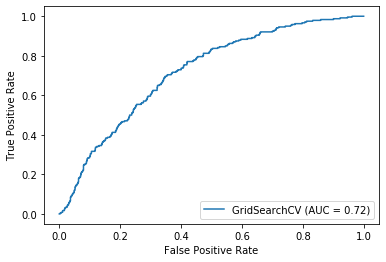

('abn_percent', 51221)              1.622480
('abn_percent', 50971)              1.099105
('abn_percent', 51222)              1.082218
ethnicity_BLACK/AFRICAN AMERICAN    1.076821
ethnicity_ASIAN                     1.068087
ethnicity_UNKNOWN                   1.008492
('abn_percent', 50882)              0.832668
ethnicity_OTHER                     0.791652
ethnicity_HISPANIC/LATINO           0.786223
('abn_percent', 51250)              0.755790
('abn_percent', 50868)              0.733121
('abn_percent', 51277)              0.721822
('abn_percent', 51249)              0.699285
('abn_percent', 50983)              0.697415
age                                 0.658560
('abn_percent', 50902)              0.612731
('abn_percent', 51006)              0.504567
('abn_percent', 51248)              0.495831
('abn_percent', 51265)              0.452326
('abn_percent', 51301)              0.337373
('abn_percent', 50912)              0.221859
('abn_percent', 51279)              0.191078
gender    

In [79]:
results(grid_log_under)

## Random Forest

### Basic

In [88]:
%%time
param_grid={'criterion': ['gini'],
            'n_estimators': range(680,721,10),
            'max_depth': range(100,130,5)
            }

grid_rf = model_selection.GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, cv=3, scoring='roc_auc')
grid_rf.fit(X_train, y_train)

CPU times: user 6min 41s, sys: 11 s, total: 6min 52s
Wall time: 7min 23s


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini'], 'max_depth': range(100, 130, 5),
                         'n_estimators': range(680, 721, 10)},
             scoring='roc_auc')

Cross Validation
--------------------
Best parameter:  {'criterion': 'gini', 'max_depth': 105, 'n_estimators': 710}
Best CV score:  0.8208
Accuracy Score: 86.45%
_______________________________________________
Classification Report:	Precision Score: 55.56%
			Recall Score: 16.67%
			F1 score: 25.64%
			ROC_AUC score: 57.25%
_______________________________________________
Confusion Matrix: 
 [[1440   32]
 [ 200   40]]



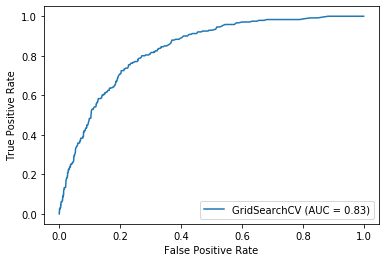

age                                        0.143728
('abn_percent', 51006)                     0.096350
('abn_percent', 50912)                     0.079882
('abn_percent', 50931)                     0.067870
('abn_percent', 51249)                     0.054745
('abn_percent', 50882)                     0.051560
('abn_percent', 51277)                     0.051405
('abn_percent', 51301)                     0.051224
('abn_percent', 50902)                     0.045172
('abn_percent', 51265)                     0.042066
('abn_percent', 51221)                     0.036433
('abn_percent', 50971)                     0.034898
('abn_percent', 50983)                     0.033095
('abn_percent', 50868)                     0.032241
('abn_percent', 51248)                     0.031970
('abn_percent', 51279)                     0.030219
('abn_percent', 51222)                     0.029567
('abn_percent', 51250)                     0.027884
gender                                     0.020515
ethnicity_BL

In [89]:
results(grid_rf)

### Over Sampling using SMOTE

In [105]:
%%time
param_grid={'criterion': ['gini'],
            'n_estimators': range(800,801,1),
            'max_depth': np.linspace(5,126,10)
            }

grid_rf_over = model_selection.GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, cv=3, scoring='roc_auc')
grid_rf_over.fit(X_res_over, y_res_over)

CPU times: user 6min 4s, sys: 10.2 s, total: 6min 14s
Wall time: 7min 9s


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini'],
                         'max_depth': array([  5.        ,  18.44444444,  31.88888889,  45.33333333,
        58.77777778,  72.22222222,  85.66666667,  99.11111111,
       112.55555556, 126.        ]),
                         'n_estimators': range(800, 801)},
             scoring='roc_auc')

Cross Validation
--------------------
Best parameter:  {'criterion': 'gini', 'n_estimators': 800}
Best CV score:  0.9760
Accuracy Score: 84.23%
_______________________________________________
Classification Report:	Precision Score: 43.30%
			Recall Score: 40.42%
			F1 score: 41.81%
			ROC_AUC score: 65.89%
_______________________________________________
Confusion Matrix: 
 [[1345  127]
 [ 143   97]]



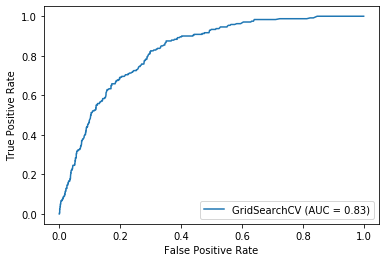

age                                        0.180585
('abn_percent', 51006)                     0.124530
('abn_percent', 50912)                     0.085566
('abn_percent', 50931)                     0.064411
('abn_percent', 51277)                     0.052614
('abn_percent', 50882)                     0.049729
('abn_percent', 51249)                     0.048462
gender                                     0.045452
('abn_percent', 51301)                     0.038462
('abn_percent', 50902)                     0.033731
('abn_percent', 51265)                     0.032868
('abn_percent', 50971)                     0.030638
('abn_percent', 51221)                     0.027855
('abn_percent', 51222)                     0.025897
('abn_percent', 50983)                     0.022960
('abn_percent', 51279)                     0.022712
('abn_percent', 51248)                     0.021205
('abn_percent', 51250)                     0.021148
('abn_percent', 50868)                     0.020430
ethnicity_BL

In [103]:
results(grid_rf_over)

### Under Sampling using Near Miss

In [35]:
%%time
param_grid={'criterion': ['gini'],
            'n_estimators': range(350,401,10),
            'max_depth': range(1,12,2)
            }

grid_rf_under = model_selection.GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, cv=3, scoring='roc_auc')
grid_rf_under.fit(X_res_under, y_res_under)

CPU times: user 2min 11s, sys: 3.16 s, total: 2min 15s
Wall time: 2min 56s


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini'], 'max_depth': range(1, 12, 2),
                         'n_estimators': range(350, 401, 10)})

Cross Validation
--------------------
Best parameter:  {'criterion': 'gini', 'max_depth': 9, 'n_estimators': 400}
Best CV score:  0.9035
Accuracy Score: 51.09%
_______________________________________________
Classification Report:	Precision Score: 20.40%
			Recall Score: 88.33%
			F1 score: 33.15%
_______________________________________________
Confusion Matrix: 
 [[681 827]
 [ 28 212]]



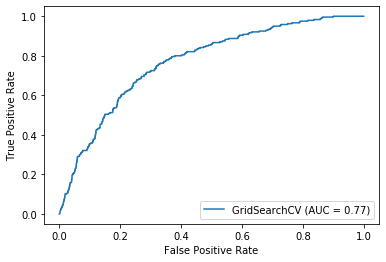

('abn_percent', 51006)                     0.109174
('abn_percent', 51277)                     0.098453
('abn_percent', 50912)                     0.070002
('abn_percent', 51003)                     0.061530
('abn_percent', 50885)                     0.061335
('abn_percent', 51237)                     0.050115
('abn_percent', 51274)                     0.047371
('abn_percent', 50902)                     0.042314
('abn_percent', 51275)                     0.040955
('abn_percent', 51498)                     0.031729
('abn_percent', 50882)                     0.026918
age                                        0.026777
('abn_percent', 51506)                     0.022398
('abn_percent', 51478)                     0.022375
('abn_percent', 50863)                     0.021440
('abn_percent', 51486)                     0.020369
('abn_percent', 50861)                     0.020054
('abn_percent', 51250)                     0.019094
('abn_percent', 51265)                     0.017499
('abn_percen

In [36]:
results(grid_rf_under)

## Gradient Boost

### basic

Cross Validation
--------------------
Best parameter:  {'n_estimators': 95}
Best CV score:  0.8751
Accuracy Score: 87.13%
_______________________________________________
Classification Report:	Precision Score: 56.88%
			Recall Score: 25.83%
			F1 score: 35.53%
_______________________________________________
Confusion Matrix: 
 [[1461   47]
 [ 178   62]]



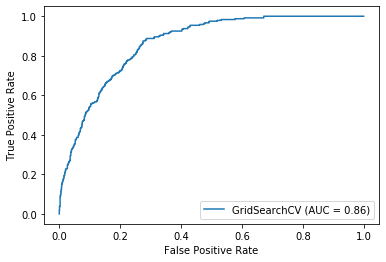

CPU times: user 18.7 s, sys: 232 ms, total: 18.9 s
Wall time: 19.1 s


In [55]:
%%time
param_grid={'n_estimators':range(85,110,5),
            }

grid_gb = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid, cv=3, scoring='roc_auc')
grid_gb.fit(X_train, y_train)

In [ ]:
results(grid_gb)

Cross Validation
--------------------
Best parameter:  {'max_depth': 3, 'max_features': 12, 'min_samples_split': 6, 'n_estimators': 95}
Best CV score:  0.8781
Accuracy Score: 87.53%
_______________________________________________
Classification Report:	Precision Score: 61.00%
			Recall Score: 25.42%
			F1 score: 35.88%
_______________________________________________
Confusion Matrix: 
 [[1469   39]
 [ 179   61]]



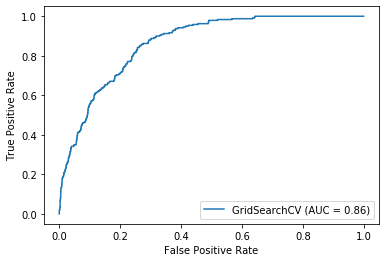

CPU times: user 53.3 s, sys: 670 ms, total: 54 s
Wall time: 54.5 s


In [61]:
%%time
param_grid={'n_estimators':[95],
            'max_depth':range(1,8,2),
            'min_samples_split':range(2,8,2),
            'max_features':range(10,15,2),
            }

grid_gb = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid, cv=3, scoring='roc_auc')
grid_gb.fit(X_train, y_train)


In [ ]:
results(grid_gb)

### Over Sampling using SMOTE¶

In [73]:
%%time
param_grid={'n_estimators':range(120,161,10),
            'max_depth':range(10,13,1),
            }

grid_gb_over = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid, cv=3, scoring='roc_auc')
grid_gb_over.fit(X_res_over, y_res_over)

CPU times: user 13min 44s, sys: 8.7 s, total: 13min 52s
Wall time: 15min 4s


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': range(10, 13),
                         'n_estimators': range(120, 161, 10)})

Cross Validation
--------------------
Best parameter:  {'max_depth': 12, 'n_estimators': 150}
Best CV score:  0.9086
Accuracy Score: 86.16%
_______________________________________________
Classification Report:	Precision Score: 49.52%
			Recall Score: 43.33%
			F1 score: 46.22%
_______________________________________________
Confusion Matrix: 
 [[1402  106]
 [ 136  104]]



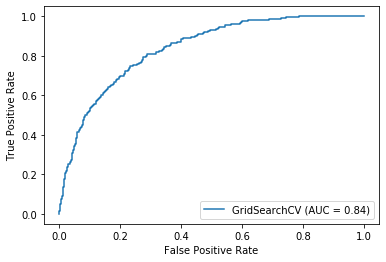

('abn_percent', 51006)                     0.308569
age                                        0.120194
gender                                     0.065190
('abn_percent', 50912)                     0.046589
('abn_percent', 50931)                     0.033402
('abn_percent', 50893)                     0.032212
('abn_percent', 51274)                     0.028017
('abn_percent', 51003)                     0.026271
('abn_percent', 50970)                     0.025380
('abn_percent', 51277)                     0.023298
('abn_percent', 51301)                     0.022504
('abn_percent', 51249)                     0.022244
('abn_percent', 51221)                     0.019728
('abn_percent', 50882)                     0.017675
('abn_percent', 51275)                     0.015628
('abn_percent', 51265)                     0.014290
('abn_percent', 50960)                     0.012975
('abn_percent', 50902)                     0.012375
('abn_percent', 50983)                     0.012180
('abn_percen

In [74]:
results(grid_gb_over)

In [ ]:
%%time
param_grid={'n_estimators':range(20,81,20),
            'max_depth':range(5,16,4),
            'min_samples_split':range(20,100,30),
            'max_features':range(7,20,5),
            }
# 'max_depth': 9, 'n_estimators': 80
grid_gb_over = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid, cv=3, scoring='roc_auc')
grid_gb_over.fit(X_res_over, y_res_over)

In [ ]:
results(grid_gb_over)

### Under Sampling using Near Miss

Cross Validation
--------------------
Best parameter:  {'n_estimators': 50}
Best CV score:  0.9150
Accuracy Score: 52.29%
_______________________________________________
Classification Report:	Precision Score: 21.22%
			Recall Score: 91.25%
			F1 score: 34.43%
_______________________________________________
Confusion Matrix: 
 [[695 813]
 [ 21 219]]



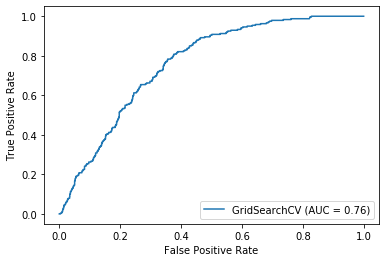

('abn_percent', 51006)                     0.413104
('abn_percent', 51274)                     0.112079
('abn_percent', 50970)                     0.075198
('abn_percent', 51277)                     0.072739
('abn_percent', 50912)                     0.037899
('abn_percent', 51003)                     0.034561
('abn_percent', 51265)                     0.034106
('abn_percent', 51275)                     0.032824
('abn_percent', 50882)                     0.030679
('abn_percent', 50902)                     0.025734
('abn_percent', 51248)                     0.022983
('abn_percent', 51222)                     0.016565
age                                        0.014636
('abn_percent', 51250)                     0.011278
('abn_percent', 51249)                     0.011056
('abn_percent', 51237)                     0.009624
('abn_percent', 51279)                     0.007495
('abn_percent', 50893)                     0.005673
('abn_percent', 50971)                     0.005553
('abn_percen

In [78]:
%%time
param_grid={'n_estimators':range(20,100,10),
            }

grid_gb_under = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid, cv=3, scoring='roc_auc')
grid_gb_under.fit(X_res_under, y_res_under)

In [ ]:
results(grid_gb_under)

Cross Validation
--------------------
Best parameter:  {'max_depth': 5, 'max_features': 7, 'min_samples_split': 80, 'n_estimators': 50}
Best CV score:  0.9093
Accuracy Score: 47.48%
_______________________________________________
Classification Report:	Precision Score: 19.89%
			Recall Score: 93.33%
			F1 score: 32.80%
_______________________________________________
Confusion Matrix: 
 [[606 902]
 [ 16 224]]



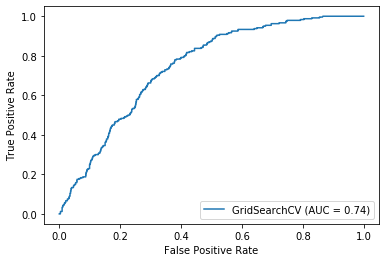

('abn_percent', 50970)                     0.097845
('abn_percent', 51006)                     0.097659
('abn_percent', 50912)                     0.085239
('abn_percent', 51277)                     0.085213
('abn_percent', 51237)                     0.075249
('abn_percent', 51222)                     0.071849
('abn_percent', 50902)                     0.069697
('abn_percent', 51274)                     0.054896
('abn_percent', 51249)                     0.054346
('abn_percent', 51003)                     0.051364
('abn_percent', 51275)                     0.050870
('abn_percent', 50882)                     0.034744
('abn_percent', 51250)                     0.031043
('abn_percent', 51265)                     0.028339
('abn_percent', 51248)                     0.016332
('abn_percent', 50971)                     0.015407
age                                        0.014550
('abn_percent', 50983)                     0.009082
('abn_percent', 50868)                     0.008894
('abn_percen

In [79]:
param_grid={'n_estimators':range(50,51,1),
            'max_depth':range(5,16,4),
            'min_samples_split':range(20,100,30),
            'max_features':range(7,20,5),
            }

grid_gb_under = model_selection.GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = param_grid, cv=3, scoring='roc_auc')
grid_gb_under.fit(X_res_under, y_res_under)

In [ ]:
results(grid_gb_under)

## Gather Metrics

In [96]:
def gather_metrics(model_list):
    '''
    Gathers metrics from models in model_list and returns a dataframe of gathered metrics.
    '''
    metrics = pd.DataFrame(columns = ['Model','F1','ROC_AUC','Recall','Accuracy','Precision'])
    
    for model, model_name in model_list:
        pred = model.best_estimator_.predict(X_test)
        
        f1 = f1_score(y_test, pred)
        roc_auc = roc_auc_score(y_test, pred)
        recall = recall_score(y_test, pred)
        accuracy = accuracy_score(y_test, pred)
        precision = precision_score(y_test, pred)
        
        metrics = metrics.append({'Model':model_name,
                                  'F1':f1,
                                  'ROC_AUC':roc_auc,
                                  'Recall':recall,
                                  'Accuracy':accuracy,
                                  'Precision':precision}
                                 ,ignore_index=True)        
    return metrics

In [97]:
model_list=[(grid_log,'logistic_basic'),(grid_log_under,'logistic_under'),(grid_log_over,'logistic_over')]
#             , 
#             (grid_gb,'gradient_boost_basic'),(grid_gb_under,'gradient_boost_under'),(grid_gb_over,'gradient_boost_over'),
#             (grid_rf,'random_forest_basic'),(grid_rf_under,'random_forest_under'),(grid_rf_over,'random_forest_over')
#            ]
gather_metrics(model_list)

,Model,F1,ROC_AUC,Recall,Accuracy,Precision
0,logistic_basic,0.441026,0.733333,0.716667,0.745327,0.318519
1,logistic_under,0.338248,0.662364,0.812500,0.554322,0.213582
2,logistic_over,0.433420,0.723551,0.691667,0.746495,0.315589


## Gather Best Features

In [100]:
def gather_best_features(model_list):
    best_features = pd.DataFrame()
#     sampling_types = ['None','Under Sample','Over Sample']
    
#     counter=0
    for model, model_name in model_list:
        if model.estimator.__class__== sklearn.linear_model._logistic.LogisticRegression:
            est_coefs = pd.Series(grid_log.best_estimator_.coef_[0], index=X_train.columns)
        else:
            est_coefs = pd.Series(model.best_estimator_.feature_importances_, index=X_train.columns)
            
        sortedCoefs = np.abs(est_coefs).sort_values(ascending=False)
        sorted_df = pd.DataFrame(sortedCoefs).reset_index().rename(columns={"index":'features', 0: model_name})
        best_features = pd.concat([best_features, sorted_df], axis=1)
    return best_features

In [101]:
gather_best_features(model_list)

,features,logistic_basic,features,logistic_under,features,logistic_over
0,age,0.924954,age,0.924954,age,0.924954
1,"('abn_percent', 51006)",0.367268,"('abn_percent', 51006)",0.367268,"('abn_percent', 51006)",0.367268
2,"('abn_percent', 51277)",0.365247,"('abn_percent', 51277)",0.365247,"('abn_percent', 51277)",0.365247
3,"('abn_percent', 51221)",0.356932,"('abn_percent', 51221)",0.356932,"('abn_percent', 51221)",0.356932
4,"('abn_percent', 51222)",0.336503,"('abn_percent', 51222)",0.336503,"('abn_percent', 51222)",0.336503
5,"('abn_percent', 50912)",0.293142,"('abn_percent', 50912)",0.293142,"('abn_percent', 50912)",0.293142
6,"('abn_percent', 50931)",0.199714,"('abn_percent', 50931)",0.199714,"('abn_percent', 50931)",0.199714
7,"('abn_percent', 51249)",0.149206,"('abn_percent', 51249)",0.149206,"('abn_percent', 51249)",0.149206
8,ethnicity_BLACK/AFRICAN AMERICAN,0.148948,ethnicity_BLACK/AFRICAN AMERICAN,0.148948,ethnicity_BLACK/AFRICAN AMERICAN,0.148948
9,gender,0.140296,gender,0.140296,gender,0.140296
